In [6]:
import  pandas as pd
import numpy as np
import  heapq
from sklearn.cross_validation import train_test_split, cross_val_score,StratifiedKFold

In [9]:
train=pd.read_csv('trainNumericEnergies.csv')

In [10]:
test=pd.read_csv('testNumericEnergies.csv')

In [11]:
train.shape

(188318, 133)

In [12]:
test.shape

(125546, 132)

In [13]:
trainvec=np.array(train)

In [14]:
testvec=np.array(test)

In [131]:
def PatternCount(text,pattern):
    """for  a  string   : 'ababcbcdcd' returns   number of occurences  of  cd  in string"""
    count=0
    for i in (range(0,((len(text))-len(pattern))+1)):
 
       
        if text[i:i+len(pattern)]==pattern:
            count+=1
            
    
    return count
def   frequentWords(text,k):
    FrequentPatterns=[]
    count=[]
    for i in range((len(text)-k)+1):
        
        pattern=text[i:i+k]
 
        if not pattern==pattern[::-1]:
          
            count.append(PatternCount(text,pattern))
    maximum=max(count)
 
    for i in range((len(text)-k)+1):
        pattern=text[i:i+k]
        if not pattern==pattern[::-1]:
            if PatternCount(text,pattern)==maximum :
                FrequentPatterns.append(text[i:i+k])
             
    return((set(FrequentPatterns),maximum))
        

In [102]:
string1="0001"
string1==string1[::-1]

False

In [103]:
catTrain=trainvec[:,1:117].astype(int)

In [104]:
catTest=testvec[:,1:117].astype(int)

In [105]:

i=0

L=list(catTrain[13,:])
text="".join(str(x) for x in L)
text

'211122111111111111111111111111111111211111111111121111111111111111111111211142244223222111214235512911245107131071124951173'

In [127]:
frequentWords(text,9)

3


({'111111112', '111111121', '111111211', '111112111', '211111111'}, 3)

In [128]:
def  kin_energy(random_vec):
    """return    kinetic  energy  of   random vector represented    as   (n,) dimmensional  array"""
    freq=np.unique(random_vec,return_counts=True)
    prob=freq[1]/random_vec.shape[0]
    energy=np.sum(prob**2)
    return  energy

In [136]:
new_feat=[]
max_freq=[]
 
length=[]
kinetic=[]
 
for  i in range(0,train.shape[0]):
    
 
    current_row=list(catTrain[i,:])
    text="".join(str(x) for x in current_row)
    derived=frequentWords(text,2)
    new_feat.append(derived[0])
    max_freq.append(derived[1])
    length.append(len(derived[0]))
    ##########do    things  for kinetic  :
    a=list(new_feat[i])
    b=[list(map(int,str(i))) for  i in a]
    c=[item for sublist in b for item in sublist]
    c=np.array(c)
    kinetic.append(kin_energy(c))
    if i%10000==0:
        print(i)
    

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000


In [143]:
train["max"]=np.array(max_freq)
train['l']=length
train['energy']=kinetic

(array([  7.01300000e+03,   7.15230000e+04,   3.89380000e+04,
          4.98890000e+04,   1.07690000e+04,   8.27000000e+03,
          1.65800000e+03,   1.68000000e+02,   8.00000000e+01,
          1.00000000e+01]),
 array([  2. ,   3.6,   5.2,   6.8,   8.4,  10. ,  11.6,  13.2,  14.8,
         16.4,  18. ]),
 <a list of 10 Patch objects>)

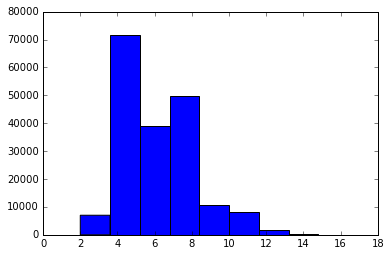

In [142]:
import  matplotlib 
from   matplotlib import pyplot  as plt
%matplotlib inline
plt.hist(np.array(max_freq))

In [ ]:
new_feat=[]
max_freq=[]
 
length=[]
kinetic=[]
 
for  i in range(0,test.shape[0]):
 
    current_row=list(catTest[i,:])
    text="".join(str(x) for x in current_row)
    derived=frequentWords(text,2)
    new_feat.append(derived[0])
    max_freq.append(derived[1])
    length.append(len(derived[0]))
    ##########do    things  for kinetic  :
    a=list(new_feat[i])
    b=[list(map(int,str(i))) for  i in a]
    c=[item for sublist in b for item in sublist]
    c=np.array(c)
    kinetic.append(kin_energy(c))
    if i%10000==0:
        print(i)

0
10000
20000
30000
40000


In [ ]:
test["max"]=np.array(max_freq)
test['l']=length
test['energy']=kinetic

In [ ]:
test.to_csv('testBio.csv',index=False)
train.to_csv('trainBio.csv',index=False)

In [50]:

# coding: utf-8

# In[ ]:

from sklearn.base import BaseEstimator
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
from __future__ import division
import pandas as pd 
import  random as random
import numpy as np
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
import heapq
class BadErrorTreshold(Exception):
    pass
class ChooseCorrectClass(Exception):
    print('1 or 0')
class EnsembleRegressors(BaseEstimator):
    ''''
    ensembleRegressor is a class of ensembles generated by a  fix number of  iterations.This class is abstract 
    meaning  it  is not possible  to create instances  of it.,,stochasticLearning''  has interface  role. '''
    def __init__(self,regressors,sampling,iterations,test,X,y):
        ''''intialize ensemble with  near all  parameters- see that   some of them are  intialized  by other methods'''
        self.test=test#final test set
        self.X=X#original train features
        self.y=y#original train outcome
        self.iterations=iterations#number of  iterations in the  stochastic ensemble
        self.regressors=regressors#ensemble models  for  each iteration
        self.sampling=sampling#dropout(cv) ratio-percentage
        self.randomIndexes=[ [] for iter in range(self.iterations)]#filled in with random dropout  by getStochasticDataSets()
        self.error=[]#error for  each averaged iteration
        self.error_after_optimization=[]
        self.stochasticPredictions=[ [] for  prediction in range(self.iterations)]#predictions on random drop outs
        self.finalPredictions=[ [] for  prediction in range(self.iterations)]#final predictions=> thi are either averaged or optimized
        self.x_train=[]#his   next  4 rows are intialized  by getStochasticDataSets() according to random chunks
        self.y_train=[]
        self.x_test=[]
        self.y_test=[]
        
    def returnError(self):
        '''returns : error for  each iteration-just like cross-validation'''
        return self.error
    
    def returnRandomIndexes(self):
        '''returns: random  indexes  for  each dropout'''
        return self.randomIndexes
    
    def returnstochasticPredictions(self):
        '''returns:predictions  on random dropous'''
        return self.stochasticPredictions
    
    def getStochasticDataSets(self):
        '''
        For some  potentially  iteration creates a random  idx variable representing the index  for random  dropout.
        Splits the train in  train/test(x_train,y_train,features and outcome for cross val train-x_test,y_test for cross_val test
        .Updated this train-test  variables with corresponding  values.See that  the initial vales are empty in the __init__.
        returns: idx(index of  dropout rows).
        
        '''    
        x_train, x_test, y_train, y_test = train_test_split(self.X, self.y, test_size=self.sampling)
        self.x_train=x_train
        self.x_test=x_test
        self.y_train=y_train
        self.y_test=y_test
        #idx=np.random.choice(range(0,self.X.shape[0]),self.sampling)
        #self.x_test=self.X[idx]
        #self.y_test=self.y[idx]
        #idx_learn=set(range(0,(self.X).shape[0]))-set(idx)
        #self.x_train=self.X[list(idx_learn)]
        #self.y_train=self.y[list(idx_learn)]
        #return  idx
    
    def training(self,i):
        ''''
        For a  particular iteration ,,i''  calls getStochasticDataSets() method.In this was the randomIndexes feature is
        fiiled with corresponding index dropouts at position ,,i''.Since train/test new data sets according to cross validation
        are   filled  by getStochasticDataSets()  independet  of iteration number , this data sets will update for each new iter.
        performmed in stochasticLearning().'''
        
        self.randomIndexes[i]=self.getStochasticDataSets()
        self.regressors_=[]#here  are appended fitted regressors
        for regressor  in self.regressors:
            trained_regressor=clone(regressor).fit(self.x_train,self.y_train)#clone from sklearn-base-clones without data
            self.regressors_.append(trained_regressor)
        return self
    
    def getFinalPrediction(self,errorTreshold):
       raise NotImplementedError###averages models  according to best top prediction  trehsold  with different implementantions
    
    
        
    
    def stochasticLearning(self):
         raise NotImplementedError#Since EnsemebleRegressors class is abstract this will act  as an interface
                                  #and will be implemented   by  this  EnsembleRegressors sublclasses  for averaging and
                                  #weighted average
    
        

class AveragingModels(EnsembleRegressors):
    '''Inherits everything from EnsembleRegressors  class and implements stochastiLearning method  averaging models 
    for each iteration'''
 
    def stochasticLearning(self):
        
        
        for iter in range(self.iterations):
            print('Stochastic Iteration number ',iter)
            self.training(iter)
            self.stochasticPredictions[iter]=[regressor.predict(self.x_test) for regressor in  self.regressors_]#updated  stochastic
            #prediction with array different shaped  predictions  at position ,,iter''
            sum=0
            for pred in range(len(self.stochasticPredictions[iter])):
                self.stochasticPredictions[iter][pred]=self.stochasticPredictions[iter][pred].reshape(self.x_test.shape[0],1)
                #reshapes prediction  in list at position iter to have the same size of  fata according to prediction
                sum=sum+self.stochasticPredictions[iter][pred]
            avg=sum/len(self.regressors)
            self.stochasticPredictions[iter]=avg#replaces corresponding list  predictions with their average
            self.error.append(mean_absolute_error(self.y_test,np.array(avg))) 
        
            #make final averaged predictions
            self.finalPredictions[iter]=[regressor.predict(self.test) for regressor in self.regressors_]#updated final predictions
            sum=0
            for pred in range(len(self.finalPredictions[iter])):
                self.finalPredictions[iter][pred]=self.finalPredictions[iter][pred].reshape(self.test.shape[0],1)
                sum=sum+self.finalPredictions[iter][pred]
            avg=sum/len(self.regressors)
            self.finalPredictions[iter]=avg
            '''For each iteration : fills prediction  in stochasticPrediction(initial empty in initialize) with corresponding
         list of arrays of predictions at position iter.For loops this position in the list  to reshape the  dropout prediction
         arrays.Since  is is  for looping average of predictions are made in same for loop.Also  appends  error between  dropout
         ground truth outcome values and predicted droputs'''
    def getFinalPrediction(self,errorTreshold):
        if (errorTreshold<=self.iterations and errorTreshold>0):
            
            topErrorIndex=heapq.nsmallest(errorTreshold, range(len(self.error)), self.error.__getitem__)
            finalAvg=0
            for topError in topErrorIndex:
                finalAvg=finalAvg+self.finalPredictions[topError]
            finalAvg=(finalAvg)/float(len(topErrorIndex))
            return finalAvg
        else:
            raise BadErrorTreshold
       
       
    
                                                
class OptimizedAverage(EnsembleRegressors):
    '''https://www.kaggle.com/hsperr/otto-group-product-classification-challenge/finding-ensamble-weights'''
    
    '''This subclass of  EnsembleRegressors inherits   everything from base class.The  implementantion of stochasticLearningis
    is different meaning it   optimize  weights  of the learnersin order to minimize the  loss metric on random dropout...'''
    
    #def __init__(self,regressors,sampling,iterations,test,X,y):
    #    '''inherits  everything  from EnsemebleRegressors even init  with  mention it  creates  a new  variable for error 
    #    after optimization'''
        
    # #   EnsembleRegressors.__init__(self,regressors,sampling,iterations,test,X,y)
    #    self.error_after_optimization=[]#error  for weighted average optimization
   
 
    def stochasticLearning(self):
 
        from scipy.optimize import minimize   
        ''''Computes also  average and weighted average in order to  compare the errors  before  and after to see gains'''
        
        for iter in range(self.iterations):
            print('Stochastic Iteration number ',iter)
            self.training(iter)
            self.stochasticPredictions[iter]=[regressor.predict(self.x_test) for regressor in  self.regressors_]#updated  stochastic
            #prediction with array different shaped  predictions  at position ,,iter''
            sum=0
            for pred in range(len(self.stochasticPredictions[iter])):
                self.stochasticPredictions[iter][pred]=self.stochasticPredictions[iter][pred].reshape(self.x_test.shape[0],1)
                #reshapes prediction  in list at position iter to have the same size of  fata according to prediction
                sum=sum+self.stochasticPredictions[iter][pred]
            avg=sum/len(self.regressors)
            self.error.append(mean_absolute_error(self.y_test,np.array(avg))) 
            predictions=self.stochasticPredictions[iter]
            
            def loss_function(weights):
                final_prediction=0
                for weight,prediction in  zip(weights,predictions):
                    final_prediction+=weight*prediction
                return mean_squared_error(self.y_test,final_prediction)
            starting_values=[0.1]*len(predictions)
            cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
            bounds = [(0,1)]*len(predictions)
            res = minimize(loss_function, starting_values, method='SLSQP', bounds=bounds)
            print('Ensamble Score: {best_score}'.format(best_score=res['fun']))
            print('Best Weights: {weights}'.format(weights=res['x']))
            print(res['fun'])
            pounds=res['x']
            yhat=0
            for i in range(len(predictions)):
                yhat+=predictions[i]*pounds[i]
            self.error_after_optimization.append(mean_squared_error(self.y_test,np.array(yhat)))
            self.finalPredictions[iter]=[regressor.predict(self.test) for regressor in self.regressors_]#updated final predictions
            test_yhat=0
            for pred in range(len(self.finalPredictions[iter])):
                self.finalPredictions[iter][pred]=self.finalPredictions[iter][pred].reshape(self.test.shape[0],1)
                test_yhat+=self.finalPredictions[iter][pred]*pounds[pred]
            self.finalPredictions[iter]=test_yhat
        
    def getFinalPrediction(self,errorTreshold):
        
        '''makes  average  of  final predictions based on top error  treshold-errorTreshold <=number of iterations'''
       
        errorType=input(' Choose  : 1 for optim error - Choose: 2 for average error retrieveing optimized prediction by error')
        if errorType==1:
            err=self.error_after_optimization
        elif erroType==2:
            err=self.error
        else :
            raise BadErrorTreshold
            
        if (errorTreshold<=self.iterations and errorTreshold>0):
            topErrorIndex=heapq.nsmallest(errorTreshold, range(len(err)),err.__getitem__)
            finalAvg=0
            for topError in topErrorIndex:
                finalAvg=finalAvg+self.finalPredictions[topError]
            finalAvg=(finalAvg)/float(len(topErrorIndex))
            return finalAvg
        else:
            raise BadErrorTreshold
            
 


1 or 0


In [32]:
import  xgboost   as xgb
xgb1=xgb.XGBRegressor(n_estimators=150)
xgb2=xgb.XGBRegressor(n_estimators=200)
xgb3=xgb.XGBRegressor(n_estimators=100)

In [49]:
a=OptimizedAverage([xgb1,xgb2],0.2,3,testvec,trainvec,y)
a.stochasticLearning()

Stochastic Iteration number  0
Ensamble Score: 14645854.712605556
Best Weights: [ 0.1  0.1]
14645854.7126
Stochastic Iteration number  1
Ensamble Score: 7418715.113540363
Best Weights: [ 1.  1.]
7418715.11354
Stochastic Iteration number  2
Ensamble Score: 14435252.505986962
Best Weights: [ 0.1  0.1]
14435252.506


In [50]:
a.error

[1412.507528224611, 1401.5218280826589, 1394.9941264148797]

In [51]:
a.error_after_optimization

[14645854.712605556, 7418715.1135403626, 14435252.505986962]

In [37]:
pred=a.getFinalPrediction(3)

In [42]:
import  matplotlib
from matplotlib  import  pyplot as plt
plt.hist(pred)
plt.show()

In [43]:
sub=pd.read_csv('sample_submission.csv')

In [46]:
sub['loss']=pred

In [48]:
sub.to_csv('sub1.csv',index=False)